# Fine tune LayoutLMv3 on custom dataset

Import modules

In [117]:
from datasets import load_from_disk

Convert Label studio labels to LayoutLMv3 format

In [120]:

dataset = load_from_disk("datasets/watercare/train_test")


In [121]:
dataset["train"].features

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-BALANCE_STILL_OWING', 'B-WATER_CONSUMPTION', 'B-WASTEWATER_CONSUMPTION', 'B-WASTEWATER_FIXED', 'B-BALANCE_CURRENT_CHARGES', 'B-TOTAL_DUE'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None),
 'id': Value(dtype='string', id=None)}

In [122]:
example = dataset['train'][1]
example

{'tokens': ['0.00', '34.12', '46.57', '20.30', '100.99', '100.99'],
 'bboxes': [[865, 395, 894, 407],
  [855, 497, 896, 509],
  [855, 510, 896, 520],
  [856, 522, 896, 532],
  [849, 531, 894, 542],
  [849, 621, 894, 633]],
 'ner_tags': [1, 1, 2, 3, 4, 5],
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=706x1000>,
 'id': '18'}

In [123]:
# Prepare dataset

In [124]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# LayoutLMv3ImageProcessor - handles resize, normalize, change mode, rescale of image before passing to model
# LayoutLMv3TokenizerFast - Tokenize input words
# Sequence: Input data -> LayoutLMv3ImageProcessor -> LayoutLMv3TokenizerFast -> input_ids, attention_mask -> token_type_ids -> bbox

In [125]:
processor

LayoutLMv3Processor:
- image_processor: LayoutLMv3ImageProcessor {
  "apply_ocr": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "LayoutLMv3FeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "LayoutLMv3ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "ocr_lang": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  },
  "tesseract_config": ""
}

- tokenizer: LayoutLMv3TokenizerFast(name_or_path='microsoft/layoutlmv3-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, 

In [126]:
from datasets.features import ClassLabel
from idp.annotations.annotation_utils import get_label_list

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.


if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [127]:
print(label_list)

['B-BALANCE_STILL_OWING', 'B-WATER_CONSUMPTION', 'B-WASTEWATER_CONSUMPTION', 'B-WASTEWATER_FIXED', 'B-BALANCE_CURRENT_CHARGES', 'B-TOTAL_DUE']


In [128]:
print(id2label)

{0: 'B-BALANCE_STILL_OWING', 1: 'B-WATER_CONSUMPTION', 2: 'B-WASTEWATER_CONSUMPTION', 3: 'B-WASTEWATER_FIXED', 4: 'B-BALANCE_CURRENT_CHARGES', 5: 'B-TOTAL_DUE'}


In [129]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [130]:
encodings = prepare_examples(dataset['train'])
encodings

{'input_ids': [[0, 321, 4, 612, 2491, 4, 245, 2766, 4, 6361, 883, 4, 996, 14512, 4, 3818, 14512, 4, 3818, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [131]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

In [132]:

train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 12
})

In [133]:
train_dataset.set_format("torch")

In [134]:
import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [135]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 3
})

In [136]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> 0.00 34.68 47.36 21.7 103.74 103.74</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [137]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 0 0
. -100
00 -100
 36 1
. -100
5 -100
 49 2
. -100
83 -100
 23 3
. -100
15 -100
 109 4
. -100
48 -100
 109 5
. -100
48 -100
</s> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -100
<pad> -1

In [138]:
from datasets import load_metric
from idp.evaluate.evaluate_utils import compute_metrics_builder

METRIC = load_metric("seqeval")

compute_metrics = compute_metrics_builder(METRIC, label_list, entity_level_metrics=False)

In [139]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="model_output",
                                  max_steps=200,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=50,
                                  save_strategy='steps',
                                  save_steps=50,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [141]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.248246,1.000000,1.000000,1.000000,1.000000
100,No log,0.030394,1.000000,1.000000,1.000000,1.000000
150,No log,0.011919,1.000000,1.000000,1.000000,1.000000
200,No log,0.008728,1.000000,1.000000,1.000000,1.000000


C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=200, training_loss=0.34496173858642576, metrics={'train_runtime': 2150.0396, 'train_samples_per_second': 0.186, 'train_steps_per_second': 0.093, 'total_flos': 105441192345600.0, 'train_loss': 0.34496173858642576, 'epoch': 33.33})

In [35]:
trainer.evaluate()

C:\Users\minhc\AppData\Local\pypoetry\Cache\virtualenvs\idp-1bLbv9p1-py3.10\lib\site-packages\transformers\modeling_utils.py:905: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 0.24824582040309906,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_f1': 1.0,
 'eval_accuracy': 1.0,
 'eval_runtime': 5.0086,
 'eval_samples_per_second': 0.599,
 'eval_steps_per_second': 0.399,
 'epoch': 33.33}

In [36]:
model.save_pretrained('test/checkpoint-2')


In [115]:

from transformers import AutoModelForTokenClassification

# Will load LayoutLMv3ForTokenClassification
model = AutoModelForTokenClassification.from_pretrained("./model_output/checkpoint-200")

In [116]:
model

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [90]:
dataset_eval = load_from_disk("dataset/eval")
example = dataset_eval[2]


In [91]:
dataset_eval

Dataset({
    features: ['tokens', 'bboxes', 'ner_tags', 'image', 'id'],
    num_rows: 3
})

In [92]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 20])
attention_mask torch.Size([1, 20])
bbox torch.Size([1, 20, 4])
labels torch.Size([1, 20])
pixel_values torch.Size([1, 3, 224, 224])


In [93]:
with torch.no_grad():
  outputs = model(**encoding)

In [94]:
logits = outputs.logits
logits.shape

torch.Size([1, 20, 6])

In [95]:
print(outputs)

TokenClassifierOutput(loss=tensor(0.1585), logits=tensor([[[ 2.3398e-01,  7.6982e-02, -2.1609e-01, -3.7095e-01, -4.9495e-01,
           3.2528e-01],
         [ 2.8021e+00,  6.7474e-01, -1.1348e+00, -8.4396e-01, -7.8344e-01,
          -9.4459e-01],
         [ 1.6372e+00,  1.6899e-01, -4.5222e-01, -4.9784e-01, -6.7474e-01,
          -3.1647e-01],
         [ 1.9019e+00,  4.9003e-01, -4.3353e-01, -4.9422e-01, -8.3333e-01,
          -5.4142e-01],
         [-1.1552e+00,  2.8201e+00, -4.9701e-01, -4.4687e-01, -8.1080e-01,
          -1.1835e+00],
         [-1.9511e-01,  1.1217e+00,  1.2273e-01, -1.1379e-01, -8.0272e-01,
          -3.4812e-01],
         [-2.4941e-01,  1.4200e+00,  3.6952e-01,  3.0335e-01, -9.7212e-01,
          -4.4754e-01],
         [-1.9489e+00, -3.1204e-01,  3.0286e+00,  8.6536e-01, -7.3593e-01,
          -1.1569e+00],
         [-9.5690e-01, -2.9110e-01,  1.0139e+00,  6.9190e-01, -2.9675e-01,
          -5.9405e-01],
         [-1.2529e+00,  1.0557e-01,  2.1475e+00,  8.0143e-0

In [96]:
predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

[5, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 2, 4, 4, 3, 5, 5, 5, 5]


In [97]:
labels = encoding.labels.squeeze().tolist()
print(encoding)

{'input_ids': tensor([[   0,  321,    4,  612, 1132,    4,  612, 3191,    4, 4390,  733,    4,
         3506, 1814,    4, 2036, 1814,    4, 2036,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'bbox': tensor([[[  0,   0,   0,   0],
         [863, 395, 894, 406],
         [863, 395, 894, 406],
         [863, 395, 894, 406],
         [855, 496, 896, 508],
         [855, 496, 896, 508],
         [855, 496, 896, 508],
         [856, 509, 895, 519],
         [856, 509, 895, 519],
         [856, 509, 895, 519],
         [856, 521, 894, 531],
         [856, 521, 894, 531],
         [856, 521, 894, 531],
         [854, 533, 894, 543],
         [854, 533, 894, 543],
         [854, 533, 894, 543],
         [856, 621, 894, 633],
         [856, 621, 894, 633],
         [856, 621, 894, 633],
         [  0,   0,   0,   0]]]), 'labels': tensor([[-100,    0, -100, -100,    1, -100, -100,    2, -100, -100,    3, -100,
         -100,    4, -100, -100, 

In [98]:
from idp.annotations.bbox_utils import unnormalize_box

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

true_boxes

[[609.278, 395.0, 631.164, 406.0],
 [603.63, 496.0, 632.576, 508.0],
 [604.336, 509.0, 631.87, 519.0],
 [604.336, 521.0, 631.164, 531.0],
 [602.924, 533.0, 631.164, 543.0],
 [604.336, 621.0, 631.164, 633.0]]

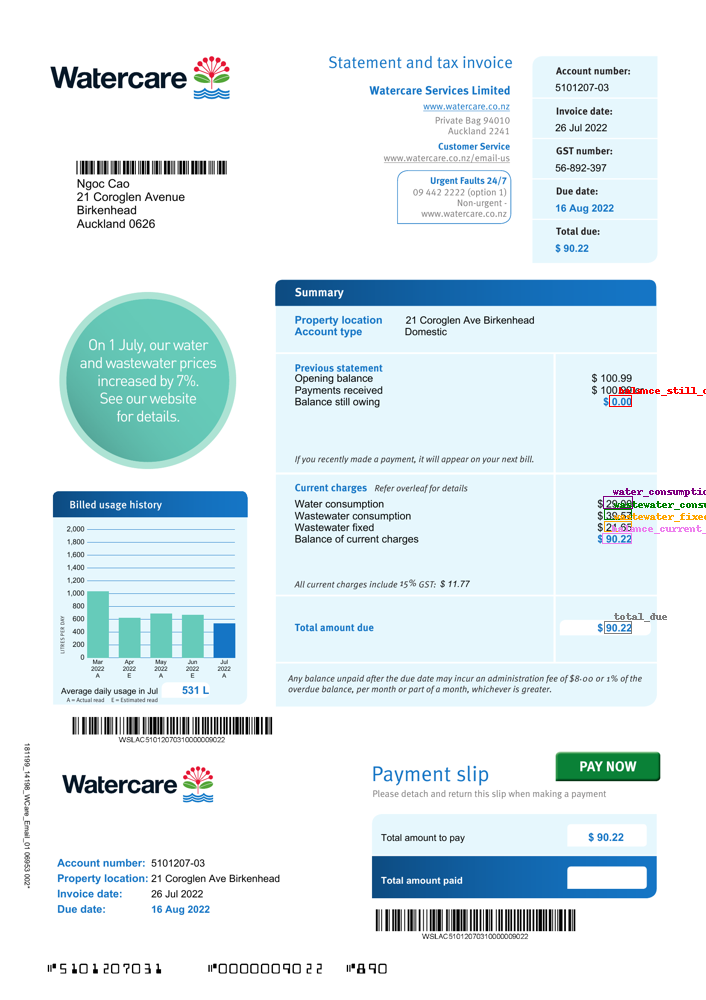

In [99]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'balance_still_owing':'red', 'water_consumption':'purple', 'wastewater_consumption':'green', 'wastewater_fixed':'orange', 'balance_current_charges':'violet',
              "total_due": "grey"}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

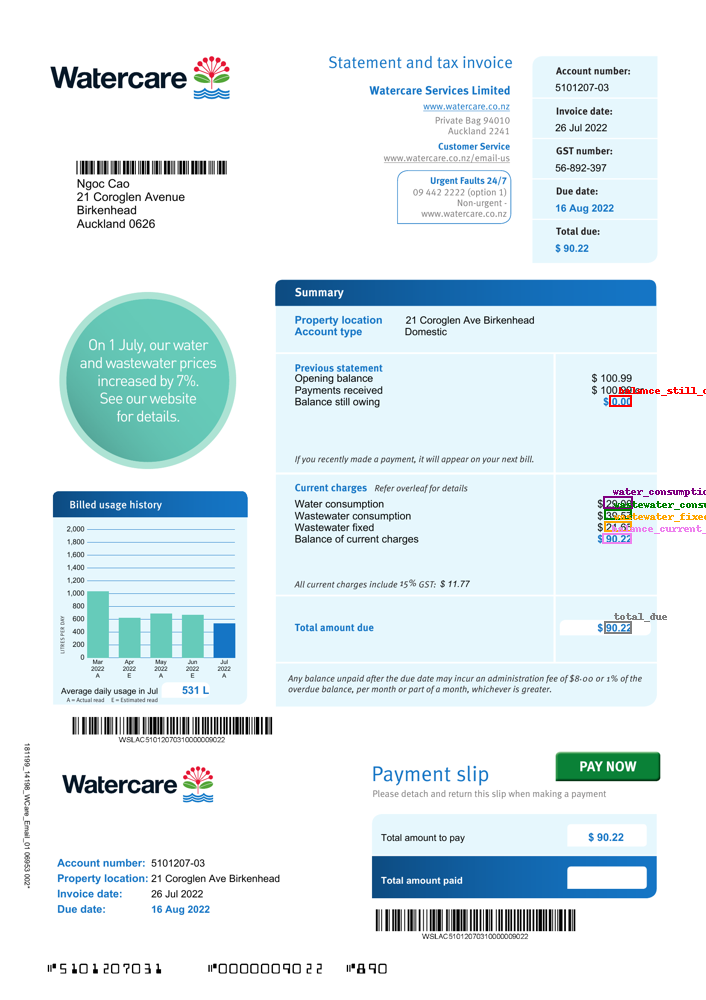

In [100]:

image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

for word, box, label in zip(example['tokens'], example['bboxes'], example['ner_tags']):
  actual_label = iob_to_label(id2label[label]).lower()
  box = unnormalize_box(box, width, height)
  draw.rectangle(box, outline=label2color[actual_label], width=2)
  draw.text((box[0] + 10, box[1] - 10), actual_label, fill=label2color[actual_label], font=font)

image